In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pickle

In [2]:
from keras.models import Model
from keras import layers
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend
from sklearn.metrics import classification_report

In [3]:
train = pd.read_csv('train.csv', low_memory=False)
train_id = pd.read_csv('train.csv', low_memory=False, usecols = ['id'])
test_id  = pd.read_csv('test.csv', low_memory=False, usecols = ['id'])
train_target = pd.read_csv('train.csv', usecols = ['target'])
embedding_matrix = pd.read_csv('data_process/embedding_matrix').values

In [4]:
totaldata = pd.read_csv('data_process/totaldata.csv',low_memory=False)

In [5]:
totaldata.shape

(10876, 53)

In [6]:
train = totaldata[totaldata['target'] != 2]
test = totaldata[totaldata['target'] == 2]

In [7]:
del totaldata['id']
del train['id']
del test['id']
del train['target']
del test['target']
del train['text']
del test['text']
del totaldata['text']

In [8]:
f_num = train.shape[1]

In [9]:
num_words = embedding_matrix.shape[0]
e_num = embedding_matrix.shape[1]

In [10]:
test.isna().any().any(), train.isna().any().any()

(False, False)

In [11]:
totaldata.columns

Index(['target', 'textsize', 'punctuation_count', 'word_mean_len',
       'haslocacion', 'keyword_t_count', 'keyword_f_count', 'keyword_metric',
       'mentions_count', 'links_count', 'label_count', 'domain_metric_mean',
       'domain_metric_std', 'domain_metric_max', 'domain_metric_min', 'PRP$',
       'NNS', 'VBP', 'DT', 'NNP', 'IN', 'NN', 'PRP', 'VBD', 'TO', 'VB', 'VBG',
       'VBN', 'JJ', 'CC', 'RB', 'VBZ', 'MD', 'EX', 'CD', 'WP', 'RP', 'NNPS',
       'JJR', 'WRB', 'JJS', 'WDT', 'RBR', 'RBS', 'FW', 'PDT', 'POS', 'UH',
       'SYM', 'WP$', ''''],
      dtype='object')

In [24]:
features_input = layers.Input(shape=(f_num,), name="features")
x = layers.Dense(1024, activation='relu')(features_input)
x = layers.Dropout(0.1)(x)
features_output = layers.Dropout(0.2)(x)

emb_input = layers.Input(shape=(None,), name="embedd")
x = layers.Embedding(num_words,e_num,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=e_num,trainable=False)(emb_input)
x = layers.SpatialDropout1D(0.08)(x)
x = layers.Conv1D(2048, 7, padding="valid", activation='relu', strides=4)(x)
x = layers.Dropout(0.1)(x)
emb_output = layers.GlobalMaxPooling1D()(x)

#x = layers.GRU(128,dropout=0.1,recurrent_dropout=0.08,return_sequences=True)(x)

x = layers.concatenate([features_output, emb_output])
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(0.12)(x)
x = layers.Dense(6,activation='relu')(x)
x = layers.Dropout(0.14)(x)
conv1d = layers.Dense(1, activation='sigmoid')(x)

model4 = Model(
    inputs=[features_input,emb_input],
    outputs=[conv1d],
)
optimzer=Adam(learning_rate=1e-5)
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimzer,
    metrics=['accuracy']
)

In [25]:
pickle_in = open("data_process/tweet_pad.pickle","rb")
tweet_pad = pickle.load(pickle_in)

In [26]:
embedd_train =tweet_pad[:train.shape[0]]
embedd_test=tweet_pad[train.shape[0]:]

In [27]:
embedd_train.shape, embedd_test.shape, train.shape, test.shape

((7613, 200), (3263, 200), (7613, 250), (3263, 250))

In [28]:
embedd_test = pd.DataFrame(embedd_test)
embedd_train = pd.DataFrame(embedd_train)

In [29]:
test.reset_index(inplace=True)
test = test.drop('index',axis=1)

In [30]:
test = pd.concat([test,embedd_test],axis=1)
train = pd.concat([train,embedd_train],axis=1)

In [31]:
train.isna().any().any() , test.isna().any().any()

(False, False)

In [32]:
scaled = MinMaxScaler()
train = pd.DataFrame(scaled.fit_transform(train), columns= train.columns)
test = pd.DataFrame(scaled.fit_transform(test), columns= test.columns)

In [33]:
model4.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedd (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3983800     embedd[0][0]                     
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, None, 200)    0           embedding_1[0][0]                
_______________________________________________________________________________________

In [34]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=6)
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [35]:
history=model4.fit(
    {"features": train.values[:,:f_num], "embedd": train.values[:,f_num:]},
    train_target.values,
    batch_size=10,
    epochs=100,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
609/609 [==============================] - 96s 158ms/step - loss: 0.6621 - accuracy: 0.6300 - val_loss: 0.6118 - val_accuracy: 0.7334
Epoch 2/100
609/609 [==============================] - 99s 163ms/step - loss: 0.5963 - accuracy: 0.7113 - val_loss: 0.5411 - val_accuracy: 0.7735
Epoch 3/100
609/609 [==============================] - 100s 165ms/step - loss: 0.5583 - accuracy: 0.7289 - val_loss: 0.5106 - val_accuracy: 0.7761
Epoch 4/100
 78/609 [==>...........................] - ETA: 1:21 - loss: 0.5532 - accuracy: 0.7269

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

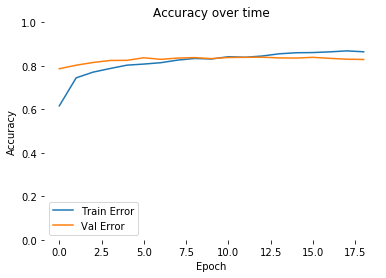

In [76]:
plot_history(history)

In [168]:
predict = model4.predict([test_features,embedd_test])
predict=np.round(predict).astype(int).reshape(3263)
submit = pd.read_csv('test.csv', usecols= ['id'])
submit['target'] = predict
submit.to_csv('submits/submit9.csv',index=False)

In [169]:
submit['target'].value_counts()

0    2031
1    1232
Name: target, dtype: int64